# Data curation 
**📊 Dataset Description 数据集说明**

### Original Data 原始数据
**RJUA-QADatasets**: 
Ant Group - Renji Hospital Urology Q&A Reasoning Dataset  
蚂蚁-仁济泌尿专科QA推理数据集 http://data.openkg.cn/dataset/rjua-qadatasets

### Data Processing Pipeline 数据处理流程

RJUA_train.json → RJUA_train_cleaned.json

**Data Cleaning Goals 数据清洗目标：** Remove redundant markers, standardize format, improve model training quality  
去除冗余标记，标准化格式，提升模型训练质量

### Data Format 数据格式

**Original Data Structure 原始数据结构：**
```json
{
    "id": "4",
    "question": "患者问题 Patient Question",
    "context": "医学背景信息 Medical Background",
    "answer": "医生回答内容 Doctor's Answer", 
    "disease": "疾病诊断 Disease Diagnosis",
    "advice": "治疗建议 Treatment Advice"
}
```

**Actual Sample Example 实际样本示例：**
```json
{
    "id": "4",
    "question": "医生您好，我是60岁男性，2天前出现右侧腰痛，尿量减少来就医。急诊CT：血指标：。请问我是什么诊断，该如何治疗？",
    "context": "临床表现：1.疼痛。2.排尿障碍：。3.高血压：。4.红细胞增多症：。检查：1.尿常规：。2.B超检查：。3.腹部X线平片：。治疗：1.非手术治疗。非手术治疗适应证：。",
    "answer": "您好，根据您的描述，你现在是 。你应该 。",
    "disease": "双侧输尿管结石伴积水感染、急性梗阻性肾衰",
    "advice": "双侧输尿管支架置入术、术后抗感染、补液、对症支持治疗"
}
```

### Data Cleaning Comparison 数据清洗对比

| Stage 阶段 | Format Example 格式示例 | Description 说明 |
| :--- | :--- | :--- |
| **Before Cleaning 清洗前** | "context":"Context：临床表现......\nContext：......[去掉引用]" | Contains redundant "Context：" prefixes and citation markers 包含冗余的"Context："前缀和引用标记 |
| **After Cleaning 清洗后** | "context":"临床表现...................." | Remove redundant markers, retain clean medical background information 去除冗余标记，保留纯净的医学背景信息 |

### Training Data Input 训练数据输入

Model training uses input data with the following key fields:  
模型训练使用的输入数据包含以下关键字段：
- `question`: Medical questions posed by patients 患者提出的医疗问题
- `context`: Relevant medical background and clinical analysis 相关的医学背景和临床分析
- `answer`: Diagnosis and treatment recommendations 诊断及治疗建议

**Data Characteristics 数据特点：**
- Focus on urological disease diagnosis and treatment 专注于泌尿系统疾病诊断与治疗
- Include complete clinical reasoning chain 包含完整的临床思维链条
- Standardized question-context-answer structure 标准化的问题-背景-回答结构
- Suitable for reasoning fine-tuning in medical Q&A scenarios 适用于医学问答场景的推理微调

### run for data curation 👇

In [ ]:
"""
Data Cleaning Module for RJUA-QADatasets
RJUA-QA数据集数据清洗模块

This module provides comprehensive text cleaning functions for medical dataset preprocessing
该模块提供全面的文本清洗功能，用于医学数据集预处理
"""

import json
import re
import os

def clean_context_references(text):
    """
    Enhanced reference cleaning function supporting all whitespace variants:
    增强版引用清洗函数，支持所有空格变种格式：
    
    Supported formats 支持的格式：
    - Basic formats 基础格式: [36], [142,143], [13-15]
    - Whitespace variants 任意空格变种: [ 36 ], [142 , 143], [13 - 15], [ 12 , 13 - 15 , 17 ]
    - Adjacent references 相邻引用: [15] [16], [15]   [16] (multiple spaces in between)
    - Special separators 特殊分隔符: Chinese comma (，), Chinese hyphen (‐), full-width space
    
    Args 参数:
        text (str): Input text containing reference markers 包含引用标记的输入文本
        
    Returns 返回:
        str: Cleaned text with all reference markers removed 去除所有引用标记的清洗后文本
    """
    # 1. Normalize Chinese symbols to English symbols (avoid format differences causing matching failures)
    # 统一替换中文符号为英文符号（避免格式差异导致匹配失败）
    text = text.replace('，', ',')  # Chinese comma → English comma 中文逗号 → 英文逗号
    text = text.replace('‐', '-')  # Chinese hyphen → English hyphen 中文短横线 → 英文短横线
    text = text.replace('\u3000', ' ')  # Full-width space → Half-width space 全角空格 → 半角空格

    # 2. Enhanced regex pattern: match all whitespace variant reference formats
    # 增强版正则表达式：匹配所有空格变种的引用格式
    ref_pattern = r'\[\s*\d+(?:\s*[,-]\s*\d+)*(?:\s*,\s*\d+(?:\s*-\s*\d+)?)*\s*\]'
    
    # 3. Replace all matched reference markers with empty string
    # 替换所有匹配的引用标记为空字符串
    cleaned_text = re.sub(ref_pattern, '', text)
    
    # 4. Clean up excessive consecutive spaces (may be left after reference removal)
    # 清理多余的连续空格（引用删除后可能留下的多个空格）
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    
    # 5. Remove leading/trailing whitespace (avoid empty lines or extra spaces)
    # 去除首尾空白（避免空行或首尾多余空格）
    return cleaned_text.strip()

def clean_context_markers(text):
    """
    Clean Context markers function, remove "Context：" and "\nContext：" strings
    清洗Context标记函数，去除"Context："和"\nContext："字符串
    
    Args 参数:
        text (str): Input text containing Context markers 包含Context标记的输入文本
        
    Returns 返回:
        str: Cleaned text with Context markers removed 去除Context标记的清洗后文本
    """
    # 1. Replace "\nContext：" with newline (preserve paragraph structure)
    # 替换"\nContext："为换行符（保持段落结构）
    cleaned_text = re.sub(r'\nContext：', '\n', text)
    
    # 2. Replace leading "Context：" (cases without preceding newline)
    # 替换开头的"Context："（没有前置换行符的情况）
    cleaned_text = re.sub(r'^Context：', '', cleaned_text)
    
    # 3. Clean up potentially generated excessive blank lines
    # 清理可能产生的多余空行
    cleaned_text = re.sub(r'\n\s*\n', '\n', cleaned_text)  # Merge multiple blank lines into one 多个空行合并为一个
    cleaned_text = cleaned_text.strip()  # Remove leading/trailing whitespace 去除首尾空白
    
    return cleaned_text

def clean_context_field(context_text):
    """
    Complete context field cleaning pipeline
    完整的context字段清洗流程
    
    Args 参数:
        context_text (str): Original context text 原始context文本
        
    Returns 返回:
        str: Fully cleaned context text 完整清洗后的context文本
    """
    if not isinstance(context_text, str):
        return context_text
    
    # Cleaning step 1: Remove Context markers
    # 清洗步骤1：去除Context标记
    cleaned = clean_context_markers(context_text)
    
    # Cleaning step 2: Remove reference markers
    # 清洗步骤2：去除引用标记
    cleaned = clean_context_references(cleaned)
    
    return cleaned

# Configuration file paths 配置文件路径
INPUT_FILE = 'RJUA_train.json'
OUTPUT_FILE = 'RJUA_train_cleaned.json'

def main():
    """
    Main execution function for data cleaning pipeline
    数据清洗流程的主要执行函数
    """
    cleaned_data = []
    error_lines = []

    # 1. Read and parse JSON Lines file
    # 读取并解析 JSON Lines 文件
    print(f"开始读取文件：{os.path.abspath(INPUT_FILE)}")
    print(f"Reading file: {os.path.abspath(INPUT_FILE)}")
    
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
            try:
                data = json.loads(line)
                cleaned_data.append(data)
            except json.JSONDecodeError as e:
                error_lines.append({
                    'line_num': line_num,
                    'content': line[:200],  # Truncate to first 200 characters 截取前200字符
                    'error': str(e)
                })

    # Output parsing statistics
    # 输出解析统计
    print(f"\n📊 解析结果 / Parsing Results：")
    print(f"✅ 成功解析 / Successfully parsed：{len(cleaned_data)} 行 / lines")
    if error_lines:
        print(f"❌ 解析失败 / Parsing failed：{len(error_lines)} 行 / lines")
        for err in error_lines[:3]:
            print(f"  行{err['line_num']} / Line {err['line_num']}：{err['error']}")
            print(f"    内容 / Content：{err['content']}...")

    # 2. Clean context field (Context markers + reference markers)
    # 清洗 context 字段（Context标记 + 引用标记）
    print(f"\n🔧 开始清洗 context 字段... / Starting context field cleaning...")
    
    # Test cases for Context marker cleaning
    # Context标记清洗的测试样例
    context_test_cases = [
        "Context：临床表现：1.疼痛：典型的表现为肾绞痛...\nContext：检查：1.尿常规：尿常规中依病因不同也可不同...",
        "Context：上尿路结石包括肾结石和输尿管结石...\nContext：所有具有泌尿系结石临床症状的患者都应该进行影像学检查...",
        "Context：治疗根据病因而定，结石可用震波碎石方法而去除..."
    ]
    
    print(f"Context标记清洗测试 / Context Marker Cleaning Test：")
    for i, test_case in enumerate(context_test_cases, 1):
        cleaned = clean_context_field(test_case)
        print(f"  测试{i} / Test {i}：")
        print(f"    原文本 / Original：{test_case[:50]}...")
        print(f"    清洗后 / Cleaned：{cleaned[:50]}...")
        print()

    # Actual data cleaning
    # 实际清洗数据
    context_cleaned_count = 0
    for idx, item in enumerate(cleaned_data):
        if 'context' in item and isinstance(item['context'], str):
            original_context = item['context']
            item['context'] = clean_context_field(original_context)
            
            # Count actually cleaned entries
            # 统计实际清洗的条目
            if original_context != item['context']:
                context_cleaned_count += 1
            
            # Verify cleaning effect for first 3 samples
            # 验证前3条样本的清洗效果
            if idx < 3:
                print(f"样本 {idx+1} Context标记清洗验证 / Sample {idx+1} Context Marker Cleaning Verification：")
                has_context_markers = "Context：" in original_context or "\nContext：" in original_context
                after_clean = "Context：" not in item['context'] and "\nContext：" not in item['context']
                print(f"  原文本含Context标记 / Original contains Context markers：{'是/Yes' if has_context_markers else '否/No'}")
                print(f"  清洗后无Context标记 / Cleaned has no Context markers：{'是/Yes' if after_clean else '否/No'}")
                print(f"  清洗效果 / Cleaning result：{'✅ 成功/Success' if has_context_markers and after_clean else '⚠️ 需检查/Need check'}")
                print()

    # 3. Save cleaned file (maintain JSON Lines format)
    # 保存清洗后的文件（保持 JSON Lines 格式）
    print(f"\n💾 保存清洗后的文件... / Saving cleaned file...")
    with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
        for item in cleaned_data:
            json.dump(item, f, ensure_ascii=False)
            f.write('\n')

    # Final results summary
    # 最终结果汇总
    print(f"\n🎉 数据清洗完成！ / Data cleaning completed!")
    print(f"📁 输出文件 / Output file：{os.path.abspath(OUTPUT_FILE)}")
    print(f"📊 有效数据条数 / Valid data entries：{len(cleaned_data)}")
    print(f"🔧 Context标记清洗 / Context marker cleaning：{context_cleaned_count} 条数据被处理 / entries processed")
    print(f"\n✅ 支持的清洗规则 / Supported cleaning rules：")
    print(f"  1. Context标记清洗 / Context marker cleaning：")
    print(f"     - 去除 'Context：' 开头标记 / Remove 'Context：' prefix markers")
    print(f"     - 去除 '\\nContext：' 段落标记 / Remove '\\nContext：' paragraph markers")
    print(f"     - 保持段落结构完整性 / Maintain paragraph structure integrity")
    print(f"  2. 引用标记清洗 / Reference marker cleaning：")
    print(f"     - 单个数字 / Single numbers：[36]、[ 36 ]、[   45   ]")
    print(f"     - 逗号分隔 / Comma separated：[142,143]、[142 , 143]、[ 142 ,143 ]")
    print(f"     - 数字范围 / Number ranges：[13-15]、[13 - 15]、[ 13-15 ]")
    print(f"     - 混合格式 / Mixed formats：[ 12 , 13 - 15 , 17 ]、[18,19-20,21]")
    print(f"     - 相邻引用 / Adjacent references：[15] [16]、[15]   [16]、[ 17 ] [ 18 - 19 ]")

if __name__ == "__main__":
    main()

# Model fine-tuning


## install libraries


## install [optional]

In [ ]:
!pip install --upgrade pip
!pip install nvitop #for GPU monitoring


## install unsloth,... requierd libraries


In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
!pip install modelscope


## skim environment 👇

In [ ]:
"""
Environment Diagnostics Script for NanoUro-LLM
NanoUro-LLM 环境诊断脚本

This script provides comprehensive environment diagnostics for ML/DL development
该脚本为机器学习/深度学习开发提供全面的环境诊断
"""

import datetime, os, platform, socket, sys, shutil
from pathlib import Path
import torch, transformers

# ---------- 0. Utility Functions 工具函数 ----------
def _get_version(pkg_name: str):
    """
    Get package version with error handling
    获取包版本号（带错误处理）
    
    Args 参数:
        pkg_name (str): Package name 包名称
        
    Returns 返回:
        str: Version string or "N/A" if not available 版本字符串或不可用时返回"N/A"
    """
    try:
        mod_name = pkg_name.replace("-", "_")
        pkg = __import__(mod_name)
        return getattr(pkg, "__version__", "unknown")
    except Exception:
        return "N/A"

# ---------- 1. Basic Information 基础信息 ----------
print("=" * 80)
print("Environment Snapshot –", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print("环境快照 -", datetime.datetime.now().strftime("%Y年%m月%d日 %H:%M:%S"))
print("=" * 80)

print("Python      :", sys.version.replace("\n", " "))
print("Python 版本 :", sys.version.replace("\n", " "))
print("Python path :", sys.executable)
print("Python 路径 :", sys.executable)

print("\n[OS Details 操作系统详情]")
print("Platform    :", platform.platform())
print("平台        :", platform.platform())
print("System      :", platform.system())
print("系统        :", platform.system())
print("Release     :", platform.release())
print("发布版本    :", platform.release())
print("Version     :", platform.version())
print("版本        :", platform.version())
print("Architecture:", platform.architecture()[0])
print("架构        :", platform.architecture()[0])

print("\n[Host & Network 主机与网络]")
print("Hostname    :", socket.gethostname())
print("主机名      :", socket.gethostname())
try:
    s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    s.connect(("8.8.8.8", 80))
    ip_addr = s.getsockname()[0]
    s.close()
    print("IP Address  :", ip_addr)
    print("IP 地址     :", ip_addr)
except Exception:
    print("IP Address  : N/A")
    print("IP 地址     : 不可用")

print("\n[Working Environment 工作环境]")
print("Working dir :", Path.cwd())
print("工作目录    :", Path.cwd())
if hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix):
    venv_type = "conda" if os.environ.get("CONDA_DEFAULT_ENV") else "virtualenv"
    venv_name = os.environ.get("CONDA_DEFAULT_ENV", "unknown") if venv_type == "conda" else Path(sys.prefix).name
    print("Virtual env :", f"{venv_type} ({venv_name})")
    print("虚拟环境    :", f"{venv_type} ({venv_name})")
else:
    print("Virtual env : None (system Python)")
    print("虚拟环境    : 无 (系统Python)")

# ---------- 2. Storage 存储 ----------
print("\n[Storage 存储]")
try:
    disk = shutil.disk_usage(Path.cwd())
    print(f"Working dir disk : Used {disk.used // 1024**3} / Total {disk.total // 1024**3} GB ({disk.used / disk.total * 100:.1f}%)")
    print(f"工作目录磁盘     : 已用 {disk.used // 1024**3} / 总计 {disk.total // 1024**3} GB ({disk.used / disk.total * 100:.1f}%)")
except Exception:
    print("Working dir disk : N/A")
    print("工作目录磁盘     : 不可用")

# ---------- 3. PyTorch / CUDA ----------
print("\n[PyTorch / CUDA]")
print("PyTorch version      :", torch.__version__)
print("PyTorch 版本         :", torch.__version__)
print("CUDA available       :", torch.cuda.is_available())
print("CUDA 可用性          :", torch.cuda.is_available())
print("CUDA version (torch) :", torch.version.cuda if torch.cuda.is_available() else "N/A")
print("CUDA 版本 (torch)    :", torch.version.cuda if torch.cuda.is_available() else "不可用")
print("cuDNN version        :", torch.backends.cudnn.version() if torch.cuda.is_available() else "N/A")
print("cuDNN 版本           :", torch.backends.cudnn.version() if torch.cuda.is_available() else "不可用")
print("GPU devices          :", torch.cuda.device_count())
print("GPU 设备数量         :", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    props = torch.cuda.get_device_properties(i)
    print(f"  └─ GPU {i}: {props.name} ({props.total_memory // 1024**2} MiB) | Compute Capability: {props.major}.{props.minor}")
    print(f"  └─ GPU {i}: {props.name} ({props.total_memory // 1024**2} MiB) | 计算能力: {props.major}.{props.minor}")

# ---------- 4. Core Dependencies 核心依赖 ----------
print("\n[Core Dependencies 核心依赖]")
print("Transformers version :", transformers.__version__)
print("Transformers 版本    :", transformers.__version__)

for pkg in ["numpy", "scipy", "accelerate", "sentencepiece", "datasets"]:
    print(f"{pkg.capitalize()} version :", _get_version(pkg))
    print(f"{pkg.capitalize()} 版本    :", _get_version(pkg))

# ---------- 5. Acceleration Backends 加速后端 ----------
print("\n[Acceleration Backends 加速后端]")
try:
    from transformers.utils.import_utils import (
        is_flash_attn_2_available,
        is_xformers_available,
        is_torch_sdpa_available,
    )
    print("Flash-Attn 2 usable  :", is_flash_attn_2_available())
    print("Flash-Attn 2 可用性  :", is_flash_attn_2_available())
    print("xFormers usable      :", is_xformers_available())
    print("xFormers 可用性      :", is_xformers_available())
    print("SDPA (torch.compile) :", is_torch_sdpa_available())
    print("SDPA (torch.compile) :", is_torch_sdpa_available())
except Exception:
    print("Flash-Attn 2 usable  : N/A")
    print("Flash-Attn 2 可用性  : 不可用")
    print("xFormers usable      : N/A")
    print("xFormers 可用性      : 不可用")
    print("SDPA (torch.compile) : N/A")
    print("SDPA (torch.compile) : 不可用")

# ---------- 6. Memory 内存 ----------
try:
    import psutil
    vm = psutil.virtual_memory()
    print("\n[Memory 内存]")
    print(f"CPU memory  : {vm.used // 1024**2} / {vm.total // 1024**2} MiB ({vm.percent} %)")
    print(f"CPU 内存    : {vm.used // 1024**2} / {vm.total // 1024**2} MiB ({vm.percent} %)")
    if torch.cuda.is_available():
        print(f"GPU memory  : {torch.cuda.memory_allocated() // 1024**2} / {torch.cuda.get_device_properties(0).total_memory // 1024**2} MiB (allocated on GPU 0)")
        print(f"GPU 内存    : {torch.cuda.memory_allocated() // 1024**2} / {torch.cuda.get_device_properties(0).total_memory // 1024**2} MiB (GPU 0 已分配)")
except ImportError:
    print("\n[Memory 内存] psutil not available, skip CPU memory dump")
    print("[Memory 内存] psutil 不可用，跳过 CPU 内存信息")

# ---------- 7. Extra Dependencies 其它依赖 ----------
print("\n[Extra Dependencies 其它依赖]")
print("Unsloth version        :", _get_version("unsloth"))
print("Unsloth 版本           :", _get_version("unsloth"))
print("ModelScope version     :", _get_version("modelscope"))
print("ModelScope 版本        :", _get_version("modelscope"))
print("PEFT version           :", _get_version("peft"))
print("PEFT 版本              :", _get_version("peft"))
print("BitsAndBytes version   :", _get_version("bitsandbytes"))
print("BitsAndBytes 版本      :", _get_version("bitsandbytes"))
print("Llama-CPP-Python       :", _get_version("llama_cpp"))
print("Llama-CPP-Python       :", _get_version("llama_cpp"))
print("psutil version         :", _get_version("psutil"))
print("psutil 版本            :", _get_version("psutil"))
print("=" * 80)
print("环境诊断完成 - Environment diagnostics completed")
print("=" * 80)

## LoRA fine-tune 👇

In [ ]:
"""
Multi-Model Medical Domain Fine-tuning Framework (Unsloth)
多模型医学领域微调框架（Unsloth）

Supports models: Qwen3, Gemma3, DeepSeek-R1-Distill series
支持模型：Qwen3、Gemma3、DeepSeek-R1-Distill 系列

Dataset: RJUA Medical Q&A Dataset (with complex chain-of-thought)
数据集：RJUA 医学问答数据集（带复杂思维链）
"""

import os
import json
import time
import torch
import shutil
import tempfile
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Any, Optional, Union
from dataclasses import dataclass
from enum import Enum

# -------------------------- Environment Configuration 环境配置 --------------------------
# Set ModelScope cache directory 设置 ModelScope 缓存目录
os.environ["MODELSCOPE_CACHE"] = "./model_cache"
# Set HuggingFace mirror endpoint (backup) 设置 HuggingFace 镜像端点（备用）
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

# Import required libraries 导入所需库
from modelscope import snapshot_download
from unsloth import FastLanguageModel
from datasets import load_dataset, Dataset
from trl import SFTTrainer
from unsloth.chat_templates import get_chat_template, train_on_responses_only
from transformers import TextStreamer, AutoTokenizer, TrainingArguments
from huggingface_hub import snapshot_download as hf_download


# ============================== 1. Download Source Enumeration 下载源枚举 ==============================
class DownloadSource(Enum):
    """Model download source options 模型下载源选项"""
    MODELSCOPE = "modelscope"      # ModelScope platform ModelScope 平台
    HUGGINGFACE = "huggingface"    # HuggingFace platform HuggingFace 平台
    LOCAL = "local"                # Local file system 本地文件系统


# ============================== 2. Model Configuration 模型配置 ==============================
class ModelFamily(Enum):
    """Supported model families 支持的模型家族"""
    QWEN3 = "qwen3"        # Qwen series models Qwen 系列模型
    GEMMA3 = "gemma3"      # Gemma series models Gemma 系列模型
    DEEPSEEK = "deepseek"  # DeepSeek series models DeepSeek 系列模型


@dataclass
class ModelConfig:
    """Model configuration class 模型配置类"""
    name: str                      # Model name 模型名称
    family: ModelFamily            # Model family 模型家族
    max_seq_length: int           # Maximum sequence length 最大序列长度
    load_in_4bit: bool            # Whether to load in 4-bit quantization 是否使用4位量化加载
    chat_template: Optional[str]  # Chat template name 聊天模板名称
    ms_id: str                    # ModelScope model ID ModelScope 模型ID
    hf_id: Optional[str] = None   # HuggingFace model ID (optional) HuggingFace 模型ID（可选）
    local_path: Optional[str] = None  # Local path (optional, takes priority) 本地路径（可选，优先使用）

    # Supported model mapping table (extensible) 支持的模型映射表（可扩展）
    MODEL_REGISTRY = {
        "qwen3-0.6b": {
            "ms_id": "unsloth/Qwen3-0.6B",
            "hf_id": "unsloth/Qwen3-0.6B",
            "family": ModelFamily.QWEN3,
            "chat_template": None,
        },
        "gemma3-270m": {
            "ms_id": "unsloth/gemma-3-270m-it", 
            "hf_id": "unsloth/gemma-3-270m-it",
            "family": ModelFamily.GEMMA3,
            "chat_template": "gemma3",
        },
        "gemma3-4b": {
            "ms_id": "unsloth/gemma-3-4b-it",
            "hf_id": "unsloth/gemma-3-4b-it", 
            "family": ModelFamily.GEMMA3,
            "chat_template": "gemma3",
        },
        "deepseek-1.5b": {
            "ms_id": "unsloth/DeepSeek-R1-Distill-Qwen-1.5B",
            "hf_id": "unsloth/DeepSeek-R1-Distill-Qwen-1.5B",
            "family": ModelFamily.DEEPSEEK,
            "chat_template": None,
        },
        "deepseek-8b": {
            "ms_id": "unsloth/DeepSeek-R1-Distill-Llama-8B",
            "hf_id": "unsloth/DeepSeek-R1-Distill-Llama-8B",
            "family": ModelFamily.DEEPSEEK,
            "chat_template": None,
        },
        "deepseek-32b": {
            "ms_id": "unsloth/DeepSeek-R1-Distill-Qwen-32B",
            "hf_id": "unsloth/DeepSeek-R1-Distill-Qwen-32B",
            "family": ModelFamily.DEEPSEEK,
            "chat_template": None,
        },
    }

    @classmethod
    def from_key(cls, key: str, max_seq_length: int = 2048, custom_path: Optional[str] = None) -> "ModelConfig":
        """
        Create configuration based on model key
        根据模型键创建配置
        
        Args:
            key (str): Model identifier 模型标识符
            max_seq_length (int): Maximum sequence length 最大序列长度
            custom_path (Optional[str]): Custom model path 自定义模型路径
            
        Returns:
            ModelConfig: ModelConfig instance ModelConfig实例
            
        Raises:
            ValueError: If model key is not supported 如果模型键不支持
        """
        # Get model information from registry 从注册表中获取模型信息
        info = cls.MODEL_REGISTRY.get(key.lower())
        if not info:
            raise ValueError(f"Unsupported model key: {key}, options: {list(cls.MODEL_REGISTRY.keys())} 不支持的模型键: {key}，可选: {list(cls.MODEL_REGISTRY.keys())}")
        
        # Create and return ModelConfig instance 创建并返回 ModelConfig 实例
        return cls(
            name=key,
            family=info["family"],
            max_seq_length=max_seq_length,
            load_in_4bit=True,
            chat_template=info["chat_template"],
            ms_id=info["ms_id"],
            hf_id=info.get("hf_id"),
            local_path=custom_path,
        )


# ============================== 3. Model Downloader 模型下载器 ==============================
class ModelDownloader:
    """Model download manager, supports multiple sources and path optimization
    模型下载管理器，支持多源下载和路径优化"""
    
    @staticmethod
    def _model_exists(path: str) -> bool:
        """
        Check if model files exist completely
        检查模型文件是否完整存在
        
        Args:
            path (str): Model path 模型路径
            
        Returns:
            bool: Whether model exists and is complete 模型是否存在且完整
        """
        # Define required model files 定义必需的模型文件
        required_files = {"config.json", "tokenizer.json", "model.safetensors"}
        # Check if directory exists 检查目录是否存在
        if not os.path.isdir(path):
            return False
        
        # Get existing files in directory 获取目录中现有文件
        existing_files = set(os.listdir(path))
        # Check if all required files exist 检查所有必需文件是否存在
        return required_files.issubset(existing_files)

    @staticmethod
    def download(config: ModelConfig, source: DownloadSource, max_retries: int = 3) -> str:
        """
        Download model from specified source
        从指定源下载模型
        
        Args:
            config (ModelConfig): Model configuration 模型配置
            source (DownloadSource): Download source 下载源
            max_retries (int): Maximum retry count 最大重试次数
            
        Returns:
            str: Local model path 模型本地路径
            
        Raises:
            ValueError: If local mode but model doesn't exist 如果本地模式但模型不存在
            RuntimeError: If model download fails 如果模型下载失败
        """
        # If local path is specified and exists, return directly
        # 如果已指定本地路径且存在，直接返回
        if config.local_path and ModelDownloader._model_exists(config.local_path):
            print(f"✅ Local model already exists: {config.local_path} 本地模型已存在: {config.local_path}")
            return config.local_path

        print(f"🔧 Downloading model from {source.value}: {config.name} 正在从 {source.value} 下载模型: {config.name}")
        
        # Check if local source but model doesn't exist 检查如果是本地源但模型不存在
        if source == DownloadSource.LOCAL:
            raise ValueError("Local mode but model doesn't exist, please check path 本地模式但模型不存在，请检查路径")

        try:
            # Download based on source 根据源下载
            if source == DownloadSource.MODELSCOPE:
                real_path = ModelDownloader._download_modelscope(config, max_retries)
            else:  # HUGGINGFACE
                real_path = ModelDownloader._download_huggingface(config, max_retries)
            
            print(f"✅ {source.value} download successful: {real_path} {source.value} 下载成功: {real_path}")
            return real_path
                
        except Exception as e:
            raise RuntimeError(
                f"❌ Model download failed!\n"
                f"   Model: {config.name}\n"
                f"   Source: {source.value}\n"
                f"   Error: {e}\n"
                f"❌ 模型下载失败！\n"
                f"   模型: {config.name}\n"
                f"   源: {source.value}\n"
                f"   错误: {e}\n"
            )

    @staticmethod
    def _download_modelscope(config: ModelConfig, max_retries: int) -> str:
        """Download model via ModelScope 通过 ModelScope 下载模型"""
        for attempt in range(1, max_retries + 1):
            try:
                print(f"🔄 Attempt {attempt} ModelScope download... 尝试第 {attempt} 次 ModelScope 下载...")
                # Download model using ModelScope 使用 ModelScope 下载模型
                real_path = snapshot_download(
                    model_id=config.ms_id,
                    cache_dir="./model_cache",
                    revision="master",
                )
                return real_path
                
            except Exception as e:
                print(f"❌ Download attempt {attempt} failed: {e} 第 {attempt} 次下载失败: {e}")
                # Exponential backoff 指数退避
                if attempt < max_retries:
                    time.sleep(2 ** attempt)
        
        raise Exception("ModelScope download retries exhausted ModelScope 下载重试次数用尽")

    @staticmethod
    def _download_huggingface(config: ModelConfig, max_retries: int) -> str:
        """Download model via HuggingFace 通过 HuggingFace 下载模型"""
        if not config.hf_id:
            raise ValueError("This model is not configured with HuggingFace ID 该模型未配置 HuggingFace ID")
            
        for attempt in range(1, max_retries + 1):
            try:
                print(f"🔄 Attempt {attempt} HuggingFace download... 尝试第 {attempt} 次 HuggingFace 下载...")
                # Download model using HuggingFace 使用 HuggingFace 下载模型
                real_path = hf_download(
                    repo_id=config.hf_id,
                    cache_dir="./model_cache",
                    local_dir_use_symlinks=False,
                )
                return real_path
                
            except Exception as e:
                print(f"❌ Download attempt {attempt} failed: {e} 第 {attempt} 次下载失败: {e}")
                # Exponential backoff 指数退避
                if attempt < max_retries:
                    time.sleep(2 ** attempt)
        
        raise Exception("HuggingFace download retries exhausted HuggingFace 下载重试次数用尽")


# ============================== 4. Model Manager 模型管理器 ==============================
class ModelManager:
    """Model loading and manager - optimized with Unsloth
    模型加载和管理器 - 基于 Unsloth 优化"""
    
    def __init__(self, config: ModelConfig):
        """
        Initialize ModelManager
        初始化模型管理器
        
        Args:
            config (ModelConfig): Model configuration 模型配置
        """
        self.config = config
        self.model = None
        self.tokenizer = None

    def load(self, download_source: DownloadSource) -> Tuple[Any, Any]:
        """
        Load model and tokenizer - using Unsloth optimized loading
        加载模型和tokenizer - 使用 Unsloth 优化加载
        
        Args:
            download_source (DownloadSource): Download source 下载源
            
        Returns:
            Tuple[Any, Any]: (model, tokenizer) 模型和分词器
            
        Raises:
            FileNotFoundError: If local model not found 如果本地模型不存在
        """
        # Get model path 获取模型路径
        if download_source == DownloadSource.LOCAL:
            if not self.config.local_path or not ModelDownloader._model_exists(self.config.local_path):
                raise FileNotFoundError(f"Local model not found: {self.config.local_path} 本地模型不存在: {self.config.local_path}")
            model_path = self.config.local_path
        else:
            model_path = ModelDownloader.download(self.config, download_source)
            
        print(f"🔧 Loading model from local: {model_path} 从本地加载模型: {model_path}")
        
        # Use Unsloth FastLanguageModel to load model and tokenizer
        # 使用 Unsloth FastLanguageModel 加载模型和tokenizer
        print("🔧 Loading model and tokenizer with Unsloth... 使用 Unsloth 加载模型和tokenizer...")
        self.model, self.tokenizer = FastLanguageModel.from_pretrained(
            model_name=model_path,
            max_seq_length=self.config.max_seq_length,
            dtype=None,  # Auto-select 自动选择
            load_in_4bit=self.config.load_in_4bit,
            load_in_8bit=False,
            token=None,  # No token needed 不使用token
            device_map="auto",  # Automatic device mapping 自动设备映射
            rope_scaling=None,  # No rope scaling 不使用rope scaling
            fix_tokenizer=True,  # Auto-fix tokenizer 自动修复tokenizer
            trust_remote_code=True,
            use_gradient_checkpointing="unsloth",  # Use unsloth gradient checkpointing 使用unsloth的梯度检查点
            random_state=3407,
        )
        
        # Update local path in config 更新配置中的本地路径
        self.config.local_path = model_path
        print(f"✅ Model loaded successfully: {self.config.name} 模型加载成功: {self.config.name}")
        return self.model, self.tokenizer

    def apply_lora(self, r: int = 16, alpha: int = 32, dropout: float = 0.0) -> None:
        """
        Apply LoRA adapter - using Unsloth optimized configuration
        应用 LoRA 适配器 - 使用 Unsloth 优化配置
        
        Args:
            r (int): LoRA rank LoRA 秩
            alpha (int): LoRA alpha parameter LoRA alpha 参数
            dropout (float): LoRA dropout rate LoRA dropout 率
        """
        self.model = FastLanguageModel.get_peft_model(
            self.model,
            r=r,
            lora_alpha=alpha,
            lora_dropout=dropout,
            target_modules=[
                "q_proj", "k_proj", "v_proj", "o_proj",
                "gate_proj", "up_proj", "down_proj"
            ],
            use_gradient_checkpointing="unsloth",
            random_state=3407,
            use_rslora=False,
            loftq_config=None,
        )
        print(f"✅ LoRA configuration completed (r={r}, alpha={alpha}, dropout={dropout}) LoRA 配置完成 (r={r}, alpha={alpha}, dropout={dropout})")

    def apply_chat_template(self) -> None:
        """Apply chat template 应用聊天模板"""
        if self.config.chat_template:
            self.tokenizer = get_chat_template(
                self.tokenizer,
                chat_template=self.config.chat_template,
            )
            print(f"✅ Chat template applied: {self.config.chat_template} 聊天模板已应用: {self.config.chat_template}")


# ============================== 5. Data Formatter 数据格式化器 ==============================
class DataFormatter:
    """Unified data format converter, ensuring training-inference consistency
    统一的数据格式转换器，确保训练-推理一致性"""
    
    # System prompt for medical domain 医学领域系统提示
    SYSTEM_PROMPT = "你是一个泌尿科医学专家，请根据患者具体情况和医学知识、临床指南，详细推理后给出专业诊断和治疗建议。"
    
    # DeepSeek specific prompt template (consistent with inference) DeepSeek专用提示模板（与推理保持一致）
    DEEPSEEK_PROMPT_TEMPLATE = """
以下是描述医疗任务的指令，以及提供更多上下文的输入（患者病史、主诉、辅助检查等）。
**先进行详细、逐步的临床推理（思维链）并用 <think> 标签包裹；随后给出结构化结论与临床决策。**

### Instruction:
"你是一个泌尿科医学专家，请根据患者具体情况和医学知识、临床指南，详细推理后给出专业诊断和治疗建议。"
请回答以下医学问题。

### Question:
{}
### Response:
<think>
{}
</think>
{}"""

    def __init__(self, family: ModelFamily):
        """
        Initialize DataFormatter
        初始化数据格式化器
        
        Args:
            family (ModelFamily): Model family 模型家族
        """
        self.family = family

    def format(self, example: Dict) -> Dict:
        """
        Format training sample
        格式化训练样本
        
        Args:
            example (Dict): Raw training example 原始训练样本
            
        Returns:
            Dict: Formatted training example 格式化后的训练样本
            
        Raises:
            ValueError: If model family is unknown 如果模型家族未知
        """
        # Extract data from example 从样本中提取数据
        question = example["question"]
        context = example["context"]  # Chain-of-thought/reasoning process 思维链/推理过程
        answer = example["answer"]
        
        # Format based on model family 根据模型家族格式化
        if self.family == ModelFamily.QWEN3:
            return self._format_qwen3(question, context, answer)
        elif self.family == ModelFamily.GEMMA3:
            return self._format_gemma3(question, context, answer)
        elif self.family == ModelFamily.DEEPSEEK:
            return self._format_deepseek(question, context, answer)
        else:
            raise ValueError(f"Unknown model family: {self.family} 未知模型家族: {self.family}")

    def _format_qwen3(self, question: str, context: str, answer: str) -> Dict:
        """
        Qwen3 format: use official chat template + <think> tag
        Qwen3格式：使用官方chat template + <think>标签
        Supports native thinking capability of the model 支持模型的原生thinking能力
        
        Args:
            question (str): User question 用户问题
            context (str): Reasoning context 推理上下文
            answer (str): Model answer 模型回答
            
        Returns:
            Dict: Formatted conversation 格式化后的对话
        """
        return {
            "conversations": [
                {"role": "system", "content": self.SYSTEM_PROMPT},
                {"role": "user", "content": question},
                {"role": "assistant", "content": f"<think>{context}</think>\n\n{answer}"}
            ]
        }

    def _format_gemma3(self, question: str, context: str, answer: str) -> Dict:
        """
        Gemma3 format: use official chat template
        Gemma3格式：使用官方chat template
        Note: Gemma3 doesn't natively support <think> tag, use natural language reasoning
        注意：Gemma3不原生支持<think>标签，使用自然语言推理
        
        Args:
            question (str): User question 用户问题
            context (str): Reasoning context 推理上下文
            answer (str): Model answer 模型回答
            
        Returns:
            Dict: Formatted conversation 格式化后的对话
        """
        # Build complete response including reasoning process 构建包含推理过程的完整回答
        full_response = f"让我先分析这个问题：\n\n{context}\n\n基于以上分析，{answer}"
        
        return {
            "conversations": [
                {"role": "system", "content": self.SYSTEM_PROMPT},
                {"role": "user", "content": question},
                {"role": "assistant", "content": full_response}
            ]
        }

    def _format_deepseek(self, question: str, context: str, answer: str) -> Dict:
        """
        DeepSeek format: use structured prompt template
        DeepSeek格式：使用结构化提示模板
        Key: Keep completely consistent with _build_prompt in InferenceTester
        关键：与InferenceTester中的_build_prompt保持完全一致
        
        Args:
            question (str): User question 用户问题
            context (str): Reasoning context 推理上下文
            answer (str): Model answer 模型回答
            
        Returns:
            Dict: Formatted data 格式化后的数据
        """
        return {
            "Question": question,
            "Complex_CoT": context,
            "Response": answer
        }


# ============================== 6. Data Pipeline 数据管道 ==============================
class DatasetPipeline:
    """Data processing pipeline - supports multiple format strategies
    数据处理管道 - 支持多种格式策略"""
    
    def __init__(self, data_path: str, config: ModelConfig, tokenizer: Any):
        """
        Initialize DatasetPipeline
        初始化数据管道
        
        Args:
            data_path (str): Path to dataset 数据集路径
            config (ModelConfig): Model configuration 模型配置
            tokenizer (Any): Tokenizer instance 分词器实例
        """
        self.data_path = data_path
        self.config = config
        self.tokenizer = tokenizer
        self.formatter = DataFormatter(config.family)

    def process(self) -> Dataset:
        """
        Process dataset
        处理数据集
        
        Returns:
            Dataset: Processed dataset 处理后的数据集
            
        Raises:
            FileNotFoundError: If dataset file not found 如果数据集文件不存在
        """
        # Check if dataset exists 检查数据集是否存在
        if not os.path.exists(self.data_path):
            raise FileNotFoundError(f"Dataset not found: {self.data_path} 数据集不存在: {self.data_path}")

        # Load dataset 加载数据集
        dataset = load_dataset("json", data_files=self.data_path, split="train")
        print(f"📊 Original data size: {len(dataset)} 原始数据量: {len(dataset)}")

        # Step 1: Format to intermediate format 步骤1: 格式化为中间格式
        dataset = dataset.map(self.formatter.format, desc="Format conversion 格式转换")

        # Step 2: Apply model-specific templates 步骤2: 应用模型特定的模板
        if self.config.family != ModelFamily.DEEPSEEK:
            # Qwen3/Gemma3: Use tokenizer's chat template Qwen3/Gemma3: 使用tokenizer的chat template
            dataset = dataset.map(
                self._apply_chat_template, 
                batched=True, 
                desc="Apply chat template 应用聊天模板"
            )
        else:
            # DeepSeek: Use custom structured template DeepSeek: 使用自定义结构化模板
            dataset = dataset.map(
                self._apply_deepseek_template, 
                batched=True, 
                desc="Apply DeepSeek template 应用DeepSeek模板"
            )

        # Preview samples 预览样本
        self._preview_samples(dataset)
        return dataset

    def _apply_chat_template(self, batch: Dict) -> Dict:
        """
        Apply official chat template for Qwen3/Gemma3
        为Qwen3/Gemma3应用官方chat template
        Utilize tokenizer's native capability 利用tokenizer的原生能力
        
        Args:
            batch (Dict): Batch of conversations 对话批次
            
        Returns:
            Dict: Batch with formatted text 格式化文本批次
        """
        texts = []
        for conversation in batch["conversations"]:
            # Key: Use tokenizer official template 关键：使用tokenizer官方模板
            text = self.tokenizer.apply_chat_template(
                conversation,
                tokenize=False,
                add_generation_prompt=False  # No generation prompt needed during training 训练时不需要generation prompt
            )
            
            # Gemma3 special handling: remove <bos> Gemma3特殊处理：移除<bos>
            if self.config.family == ModelFamily.GEMMA3:
                text = text.removeprefix("<bos>")
            
            texts.append(text)
        
        return {"text": texts}

    def _apply_deepseek_template(self, batch: Dict) -> Dict:
        """
        DeepSeek specific template application
        DeepSeek专用模板应用
        Use structured prompt template, ensure format is completely consistent with inference
        使用结构化prompt template，确保与推理时格式完全一致
        
        Args:
            batch (Dict): Batch of data 数据批次
            
        Returns:
            Dict: Batch with formatted text 格式化文本批次
        """
        # Determine correct EOS token 确定正确的EOS token
        if "deepseek" in self.config.name.lower():
            eos_token = ""
        else:
            eos_token = self.tokenizer.eos_token
        
        texts = []
        for question, cot, response in zip(
            batch["Question"], 
            batch["Complex_CoT"], 
            batch["Response"]
        ):
            # Key: Use template format including chain-of-thought 关键：使用包含思维链模板格式
            text = DataFormatter.DEEPSEEK_PROMPT_TEMPLATE.format(
                question,  # Fill question 填充问题
                cot,       # Fill chain-of-thought 填充思维链
                response   # Fill response 填充回答
            ) + eos_token
            
            texts.append(text)
        
        return {"text": texts}

    def _preview_samples(self, dataset: Dataset) -> None:
        """
        Data sample preview
        数据样本预览
        
        Args:
            dataset (Dataset): Processed dataset 处理后的数据集
        """
        print("\n" + "="*80)
        print("📋 Data sample preview (first 2000 characters): 数据样本预览（前2000字符）:")
        sample_text = dataset[0]["text"]
        preview = sample_text[:2000] + "..." if len(sample_text) > 2000 else sample_text
        print(preview)
        print("="*80 + "\n")


# ============================== 7. Training Manager 训练管理器 ==============================
class TrainingManager:
    """Training process manager - optimized with Unsloth
    训练流程管理器 - 基于 Unsloth 优化"""
    
    def __init__(self, model: Any, tokenizer: Any, dataset: Dataset, 
                config: ModelConfig, output_dir: str):
        """
        Initialize TrainingManager
        初始化训练管理器
        
        Args:
            model (Any): Model instance 模型实例
            tokenizer (Any): Tokenizer instance 分词器实例
            dataset (Dataset): Training dataset 训练数据集
            config (ModelConfig): Model configuration 模型配置
            output_dir (str): Output directory 输出目录
        """
        self.model = model
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.config = config
        self.output_dir = output_dir
        self.trainer = None

    def build_trainer(self, **training_args) -> SFTTrainer:
        """
        Build trainer - using Unsloth optimized configuration
        构建训练器 - 使用 Unsloth 优化配置
        
        Args:
            **training_args: Training parameters 训练参数
            
        Returns:
            SFTTrainer: Configured trainer 配置好的训练器
        """
        # Training configuration - reference Unsloth official recommended parameters
        # 训练配置 - 参考 Unsloth 官方推荐参数
        args = TrainingArguments(
            output_dir=self.output_dir,
            per_device_train_batch_size=training_args.get("batch_size", 4),
            gradient_accumulation_steps=training_args.get("grad_accumulation_steps", 2),
            learning_rate=training_args.get("learning_rate", 2e-4),
            max_steps=training_args.get("max_steps", 200),
            warmup_steps=training_args.get("warmup_steps", 10),
            logging_steps=training_args.get("logging_steps", 1),
            save_steps=training_args.get("save_steps", 100),
            optim="adamw_8bit",  # 8-bit AdamW optimizer, reduces VRAM usage 8位AdamW优化器，减少显存占用
            weight_decay=0.01,
            lr_scheduler_type="linear",
            seed=3407,
            report_to="none",
            fp16=not torch.cuda.is_bf16_supported(),
            bf16=torch.cuda.is_bf16_supported(),  # BF16 has larger dynamic range BF16动态范围更大
        )

        # Create trainer 创建训练器
        trainer = SFTTrainer(
            model=self.model,
            tokenizer=self.tokenizer,
            train_dataset=self.dataset,
            dataset_text_field="text",
            max_seq_length=self.config.max_seq_length,
            args=args,
            dataset_num_proc=2,  # 2 process data processing 2进程数据处理
            packing=False,       # Whether to pack multiple short sequences into one long sequence for training 是否将多个短序列打成一个长序列训练
        )

        # Only calculate assistant part loss 仅计算 assistant 部分的损失
        if self.config.family in {ModelFamily.QWEN3, ModelFamily.GEMMA3}:
            if self.config.family == ModelFamily.QWEN3:
                trainer = train_on_responses_only(
                    trainer, "<|im_start|>user", "<|im_start|>assistant"
                )
            else:  # Gemma3
                trainer = train_on_responses_only(
                    trainer, "<start_of_turn>user", "<start_of_turn>model"
                )

        self.trainer = trainer
        return trainer

    def train(self) -> Dict:
        """
        Execute training
        执行训练
        
        Returns:
            Dict: Training statistics 训练统计信息
        """
        print("🚀 Starting training... 开始训练...")
        start_time = time.time()
        
        # Execute training 执行训练
        training_stats = self.trainer.train()
        
        # Calculate training time 计算训练时间
        training_time = time.time() - start_time
        print(f"✅ Training completed, time taken: {training_time:.2f} seconds 训练完成，耗时: {training_time:.2f} 秒")
        
        # Plot loss curve 绘制损失曲线
        self._plot_training_loss()
        
        return training_stats

    def _plot_training_loss(self) -> None:
        """Plot training loss curve - fresh theme version 绘制训练损失曲线 - 清新主题版本"""
        try:
            # Get loss logs from trainer state 从训练器的状态中获取损失日志
            if not self.trainer or not hasattr(self.trainer, 'state') or not self.trainer.state.log_history:
                print("⚠️ No training loss data found 未找到训练损失数据")
                return

            logs = self.trainer.state.log_history

            # Extract training steps and loss 提取训练步骤和损失
            steps = []
            losses = []

            for log in logs:
                if "loss" in log and "step" in log:
                    steps.append(log["step"])
                    losses.append(log["loss"])

            if not steps:
                print("⚠️ No valid loss data found 未找到有效的损失数据")
                return

            # Create fresh style chart 创建清新风格的图表
            plt.figure(figsize=(10, 6))

            # Use fresh color scheme 使用清新配色方案
            plt.plot(steps, losses, color='#2E86AB', linewidth=2.5, label="Training Loss", marker='o', markersize=4)
            plt.xlabel("Steps", fontsize=12)
            plt.ylabel("Loss", fontsize=12)
            plt.title(f"{self.config.name} - Training Loss Curve", fontsize=14, fontweight='bold')

            # Set fresh grid and background 设置清新网格和背景
            plt.grid(True, alpha=0.3, linestyle='--', color='#A5B1C2')
            plt.gca().set_facecolor('#F7F9FC')
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)

            plt.legend(frameon=True, fancybox=True, framealpha=0.9)

            # Save chart 保存图表
            loss_plot_path = f"{self.output_dir}/training_loss.png"
            plt.savefig(loss_plot_path, dpi=300, bbox_inches="tight", facecolor='#F7F9FC')
            plt.close()

            print(f"📈 Loss curve saved: {loss_plot_path} 损失曲线已保存: {loss_plot_path}")

        except Exception as e:
            print(f"⚠️ Failed to plot loss curve: {e} 绘制损失曲线失败: {e}")


# ============================== 8. Inference Tester 推理测试器 ==============================
class InferenceTester:
    """Model inference tester 模型推理测试器"""
    
    # Model inference parameter presets - reference official recommendations
    # 模型推理参数预设 - 参考官方推荐参数
    INFERENCE_PRESETS = {
        "qwen3-0.6b": {
            "temperature": 0.6,
            "top_p": 0.95,
            "top_k": 20,
            "repetition_penalty": 1.0,
            "enable_thinking": True  # Qwen3 thinking mode Qwen3 思维模式
        },
        "gemma3-270m": {
            "temperature": 1.0, 
            "top_p": 0.95,
            "top_k": 64,
            "repetition_penalty": 1.05,
            "enable_thinking": False
        },
        "gemma3-4b": {
            "temperature": 1.0,
            "top_p": 0.95, 
            "top_k": 64,
            "repetition_penalty": 1.05,
            "enable_thinking": False
        },
        "deepseek-1.5b": {
            "temperature": 0.6,
            "top_p": 0.95,
            "repetition_penalty": 1.0,
            "enable_thinking": True  # DeepSeek thinking mode DeepSeek 思维模式
        },
        "deepseek-8b": {
            "temperature": 0.6,
            "top_p": 0.95,
            "repetition_penalty": 1.0,
            "enable_thinking": True
        },
        "deepseek-32b": {
            "temperature": 0.6,
            "top_p": 0.95,
            "repetition_penalty": 1.0,
            "enable_thinking": True  # Continue using DeepSeek thinking mode 沿用 DeepSeek 思维模式
        }
    }

    def __init__(self, model: Any, tokenizer: Any, config: ModelConfig):
        """
        Initialize InferenceTester
        初始化推理测试器
        
        Args:
            model (Any): Model instance 模型实例
            tokenizer (Any): Tokenizer instance 分词器实例
            config (ModelConfig): Model configuration 模型配置
        """
        self.model = model
        self.tokenizer = tokenizer
        self.config = config
        # Get inference preset for the model 获取模型的推理预设
        self.preset = self.INFERENCE_PRESETS.get(
            config.name.lower(), 
            self.INFERENCE_PRESETS["gemma3-270m"]  # Default fallback 默认回退
        )

    def test(self, dataset: Dataset, sample_index: int = 0) -> None:
        """
        Execute inference test
        执行推理测试
        
        Args:
            dataset (Dataset): Dataset for testing 测试数据集
            sample_index (int): Sample index 样本索引
        """
        # Get sample and build prompt 获取样本并构建提示
        sample = dataset[sample_index]
        prompt = self._build_prompt(sample)
        
        print("\n🎯 Input prompt: 输入提示:")
        print(prompt)
        print("\n🤖 Model output: 模型输出:")
        print("-" * 80)

        # Tokenize input 对输入进行分词
        inputs = self.tokenizer([prompt], return_tensors="pt").to("cuda")
        # Create text streamer for real-time output 创建文本流式输出器用于实时输出
        streamer = TextStreamer(self.tokenizer, skip_prompt=True)

        # Generation configuration 生成配置
        generation_config = {
            "do_sample": True,
            "temperature": self.preset["temperature"],
            "top_p": self.preset["top_p"],
            "top_k": self.preset.get("top_k", 40),
            "max_new_tokens": 2048,
            "repetition_penalty": self.preset["repetition_penalty"],
            "eos_token_id": self.tokenizer.eos_token_id,
            "streamer": streamer,
        }

        # Generate output 生成输出
        with torch.no_grad():
            outputs = self.model.generate(**inputs, **generation_config)
            
        print("-" * 80)

    def _build_prompt(self, sample: Dict) -> str:
        """
        Build inference prompt - key: completely correspond to training format
        构建推理提示 - 关键：与训练格式完全对应
        
        Args:
            sample (Dict): Sample data 样本数据
            
        Returns:
            str: Formatted prompt 格式化后的提示
        """
        if self.config.family == ModelFamily.DEEPSEEK:
            # DeepSeek: use structured template (excluding CoT and Response parts)
            # DeepSeek：使用结构化模板（不包含CoT和Response部分）
            question = sample["Question"]
            prompt_template = """
            以下是描述医疗任务的指令，以及提供更多上下文的输入（患者病史、主诉、辅助检查等）。
                **先进行详细、逐步的临床推理（思维链）并用 <think> 标签包裹；随后给出结构化结论与临床决策。**
                ### Instruction:
                "你是一个泌尿科医学专家，请根据患者具体情况和医学知识、临床指南，详细推理后给出专业诊断和治疗建议。"
                请回答以下医学问题。
                ### Question:
                {}
                ### Response:
                <think>"""
            return prompt_template.format(question)
            
        else:
            # Qwen3/Gemma3: use chat template Qwen3/Gemma3：使用chat template
            if "conversations" in sample:
                messages = sample["conversations"][:2]  # system + user
            else:
                # Rebuild messages from formatted data 从格式化后的数据重建messages
                messages = [
                    {"role": "system", "content": DataFormatter.SYSTEM_PROMPT},
                    {"role": "user", "content": sample.get("Question", "")}
                ]
            
            prompt = self.tokenizer.apply_chat_template(
                messages, 
                tokenize=False, 
                add_generation_prompt=True,
                enable_thinking=self.preset.get("enable_thinking", False)
            )
            
            # Gemma3 special handling Gemma3特殊处理
            if self.config.family == ModelFamily.GEMMA3:
                prompt = prompt.removeprefix("<bos>")
            
            return prompt


# ============================== 9. Model Saver 模型保存器 ==============================
class ModelSaver:
    """Model saving manager 模型保存管理器"""
    
    def __init__(self, model: Any, tokenizer: Any, save_dir: str):
        """
        Initialize ModelSaver
        初始化模型保存器
        
        Args:
            model (Any): Model instance 模型实例
            tokenizer (Any): Tokenizer instance 分词器实例
            save_dir (str): Save directory 保存目录
        """
        self.model = model
        self.tokenizer = tokenizer
        self.save_dir = save_dir
        # Create save directory if not exists 如果保存目录不存在则创建
        os.makedirs(save_dir, exist_ok=True)

    def save_lora(self) -> None:
        """Save LoRA adapter 保存 LoRA 适配器"""
        self.model.save_pretrained(self.save_dir)
        self.tokenizer.save_pretrained(self.save_dir)
        print(f"💾 LoRA adapter saved: {self.save_dir} LoRA 适配器已保存: {self.save_dir}")

    def save_merged_16bit(self) -> None:
        """Save merged 16bit model 保存合并的 16bit 模型"""
        merged_path = f"{self.save_dir}_merged_16bit"
        self.model.save_pretrained_merged(
            merged_path, 
            self.tokenizer, 
            save_method="merged_16bit"
        )
        print(f"💾 16bit merged model saved: {merged_path} 16bit 合并模型已保存: {merged_path}")

    def save_gguf(self, quantization: str = "q8_0") -> None:
        """Save GGUF format model 保存 GGUF 格式模型"""
        gguf_path = f"{self.save_dir}_gguf_{quantization}"
        self.model.save_pretrained_gguf(
            gguf_path, 
            self.tokenizer, 
            quantization_method=quantization
        )
        print(f"💾 GGUF ({quantization}) model saved: {gguf_path} GGUF ({quantization}) 模型已保存: {gguf_path}")


# ============================== 10. Main Process Controller 主流程控制器 ==============================
class MedicalFineTuningFramework:
    """Medical domain fine-tuning framework main controller
    医学领域微调框架主控制器"""
    
    def __init__(self):
        """Initialize framework 初始化框架"""
        self.config = None
        self.model = None
        self.tokenizer = None
        self.dataset = None

    def setup_model(self, 
                model_key: str, 
                download_source: Union[str, DownloadSource],
                custom_model_path: Optional[str] = None,
                max_seq_length: int = 2048) -> None:
        """
        Set up model configuration and loading
        设置模型配置和加载
        
        Args:
            model_key (str): Model identifier 模型标识符
            download_source (Union[str, DownloadSource]): Download source 下载源
            custom_model_path (Optional[str]): Custom model path 自定义模型路径
            max_seq_length (int): Maximum sequence length 最大序列长度
            
        Raises:
            ValueError: If model setup fails 如果模型设置失败
        """
        # Configuration parsing 配置解析
        download_source_enum = DownloadSource(download_source.lower())
        print(f"🔧 Configuring model: {model_key} 配置模型: {model_key}")
        print(f"🔧 Download source: {download_source_enum.value} 下载源: {download_source_enum.value}")
        
        # Create model configuration 创建模型配置
        self.config = ModelConfig.from_key(
            model_key, 
            max_seq_length=max_seq_length,
            custom_path=custom_model_path
        )

        # Model loading and preparation 模型加载和准备
        print("\n📥 Loading model... 加载模型中...")
        manager = ModelManager(self.config)
        self.model, self.tokenizer = manager.load(download_source_enum)
        
        print("✅ Model setup completed 模型设置完成")

    def setup_lora(self, r: int = 16, alpha: int = 32, dropout: float = 0.0) -> None:
        """
        Set up LoRA configuration
        设置 LoRA 配置
        
        Args:
            r (int): LoRA rank LoRA 秩
            alpha (int): LoRA alpha parameter LoRA alpha 参数
            dropout (float): LoRA dropout rate LoRA dropout 率
            
        Raises:
            ValueError: If model is not loaded 如果模型未加载
        """
        if not self.model or not self.tokenizer:
            raise ValueError("Please call setup_model() to load model first 请先调用 setup_model() 加载模型")
            
        manager = ModelManager(self.config)
        manager.model = self.model
        manager.tokenizer = self.tokenizer
        manager.apply_lora(r=r, alpha=alpha, dropout=dropout)
        manager.apply_chat_template()
        
        self.model = manager.model
        self.tokenizer = manager.tokenizer
        print("✅ LoRA configuration completed LoRA 配置完成")

    def setup_data(self, data_path: str) -> None:
        """
        Set up and preprocess data
        设置和预处理数据
        
        Args:
            data_path (str): Data file path 数据文件路径
            
        Raises:
            ValueError: If model is not loaded 如果模型未加载
        """
        if not self.model or not self.tokenizer:
            raise ValueError("Please call setup_model() to load model first 请先调用 setup_model() 加载模型")
            
        print("\n📊 Processing dataset... 处理数据集中...")
        pipeline = DatasetPipeline(data_path, self.config, self.tokenizer)
        self.dataset = pipeline.process()
        print("✅ Data setup completed 数据设置完成")

    def train(self, 
            output_dir: str = "outputs",
            max_steps: int = 200,
            batch_size: int = 4,
            learning_rate: float = 2e-4) -> Dict:
        """
        Execute training process
        执行训练流程
        
        Args:
            output_dir (str): Output directory 输出目录
            max_steps (int): Maximum training steps 最大训练步数
            batch_size (int): Batch size 批次大小
            learning_rate (float): Learning rate 学习率
            
        Returns:
            Dict: Training statistics 训练统计信息
            
        Raises:
            ValueError: If initialization is incomplete 如果初始化未完成
        """
        if not self.model or not self.tokenizer or not self.dataset:
            raise ValueError("Please complete initialization with setup_model(), setup_lora(), setup_data() first 请先调用 setup_model(), setup_lora(), setup_data() 完成初始化")

        print("\n🎯 Configuring training... 配置训练中...")
        training_manager = TrainingManager(
            self.model, self.tokenizer, self.dataset, self.config, output_dir
        )
        
        # Build trainer 构建训练器
        trainer = training_manager.build_trainer(
            max_steps=max_steps,
            batch_size=batch_size, 
            learning_rate=learning_rate
        )
        
        # Execute training 执行训练
        training_stats = training_manager.train()
        print("✅ Training completed 训练完成")
        return training_stats

    def inference_test(self, sample_index: int = 0) -> None:
        """
        Execute inference test
        执行推理测试
        
        Args:
            sample_index (int): Sample index 样本索引
            
        Raises:
            ValueError: If initialization is incomplete 如果初始化未完成
        """
        if not self.model or not self.tokenizer or not self.dataset:
            raise ValueError("Please complete model and data setup first 请先完成模型和数据设置")

        print("\n🧪 Executing inference test... 执行推理测试...")
        tester = InferenceTester(self.model, self.tokenizer, self.config)
        tester.test(self.dataset, sample_index)
        print("✅ Inference test completed 推理测试完成")

    def save_model(self, save_dir: str, save_method: str = "lora") -> None:
        """
        Save trained model
        保存训练好的模型
        
        Args:
            save_dir (str): Save directory 保存目录
            save_method (str): Save method ('lora', 'merged_16bit', 'gguf') 保存方法 ('lora', 'merged_16bit', 'gguf')
            
        Raises:
            ValueError: If no model to save or invalid save method 如果没有可保存的模型或无效的保存方法
        """
        if not self.model or not self.tokenizer:
            raise ValueError("No model to save 没有可保存的模型")

        print("\n💾 Saving model... 保存模型中...")
        saver = ModelSaver(self.model, self.tokenizer, save_dir)
        
        # Save based on method 根据方法保存
        if save_method == "lora":
            saver.save_lora()
        elif save_method == "merged_16bit":
            saver.save_merged_16bit()
        elif save_method == "gguf":
            saver.save_gguf()
        else:
            raise ValueError(f"Unsupported save method: {save_method} 不支持的保存方法: {save_method}")
            
        print(f"✅ Model save completed: {save_dir} 模型保存完成: {save_dir}")


def main():
    """
    Main training process example
    主训练流程示例
    """
    print("\n" + "="*80)
    print("🏥 Medical Multi-Model Unified Fine-tuning Framework 医学多模型统一微调框架")
    print("="*80)
    
    try:
        # Create framework instance 创建框架实例
        framework = MedicalFineTuningFramework()
        
        # 1. Model setup 模型设置
        framework.setup_model(
            model_key="deepseek-8b",           # Model selection (using small model for testing) 模型选择（使用小模型测试）
            download_source="modelscope",      # Download source 下载源
            max_seq_length=4096,               # Sequence length 序列长度
            # custom_model_path="./my_local_model"  # Optional: custom local path 可选：自定义本地路径
        )
        
        # 2. LoRA configuration LoRA 配置
        framework.setup_lora(
            r=8,                             # LoRA rank LoRA 秩
            alpha=16,                         # LoRA alpha LoRA alpha
            dropout=0.0,                      # LoRA dropout LoRA dropout
        )
        
        # 3. Data setup 数据设置
        framework.setup_data(
            data_path="RJUA_train_cleaned.json"  # Data path 数据路径
        )
        
        # 4. Training 训练
        training_stats = framework.train(
            output_dir="outputs",              # Output directory 输出目录
            max_steps=10,                     # Training steps (for quick testing 10) 训练步数（测试用），actual 1705*saamples/4*batch/2*gradients accumualtion like 214
            batch_size=4,                      # Batch size 批次大小
            learning_rate=2e-4,                # Learning rate 学习率
        )
        
        # 5. Inference test 推理测试
        framework.inference_test(sample_index=0)
        
        # 6. Model save 模型保存
        save_dir = f"outputs/deepseek-8b_lora"
        framework.save_model(save_dir, save_method="lora")

        print(f"\n🎉 All processes completed! 全部流程完成！")
        print(f"📁 Model saved at: {save_dir} 模型保存在: {save_dir}")

    except Exception as e:
        print(f"\n❌ Training process terminated abnormally: {e} 训练流程异常终止: {e}")
        raise


if __name__ == "__main__":
    # Ignore warnings 忽略警告
    import warnings
    warnings.filterwarnings("ignore")
    
    # Execute main process 执行主流程
    main()

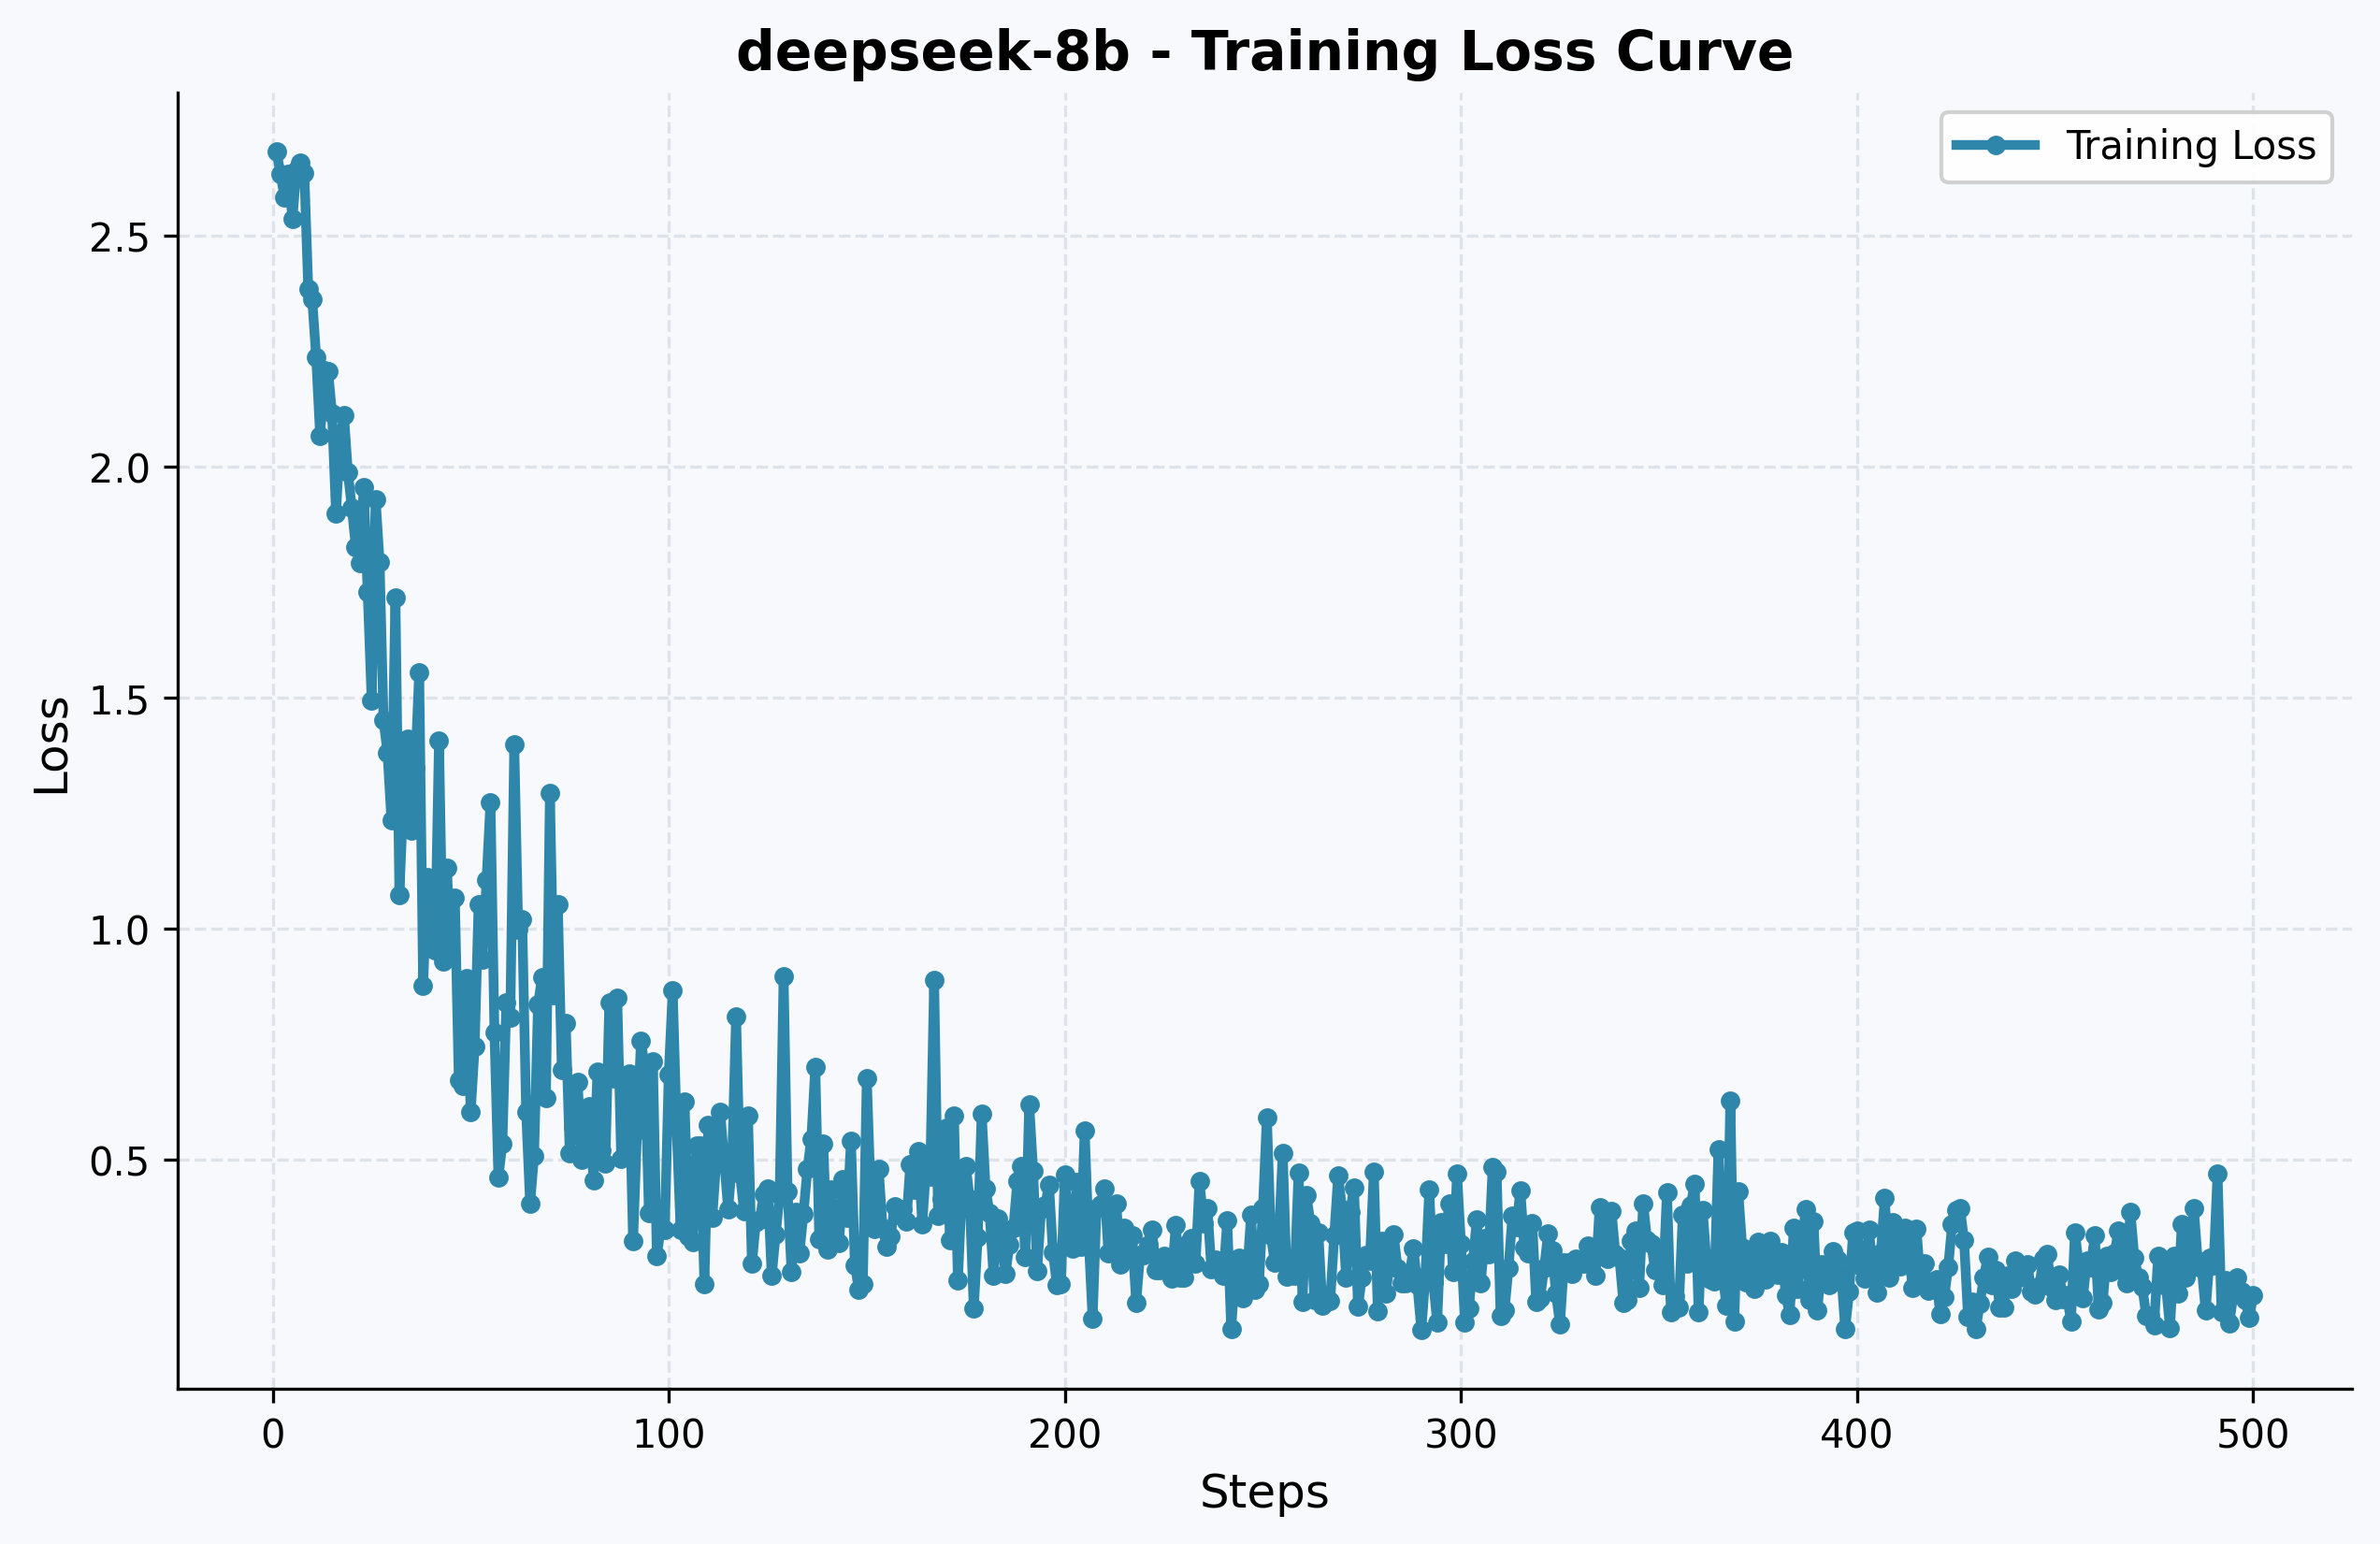

# Inference sample

In [ ]:
import os
import torch
from unsloth import FastLanguageModel
from peft import PeftModel  
from typing import Tuple, Optional, Dict, Any
from dataclasses import dataclass, field
from enum import Enum

class ModelFamily(Enum):
    """Model Family Enumeration 模型家族枚举"""
    DEEPSEEK = "deepseek"  # DeepSeek model series DeepSeek模型系列
    QWEN3 = "qwen3"        # Qwen3 model series Qwen3模型系列
    GEMMA3 = "gemma3"      # Gemma3 model series Gemma3模型系列


@dataclass
class ModelConfig:
    """Unified Model Configuration 统一模型配置"""
    name: str                      # Model name 模型名称
    family: ModelFamily           # Model family 模型家族
    max_seq_length: int = 4096    # Maximum sequence length 最大序列长度
    load_in_4bit: bool = True     # Whether to load in 4-bit 是否使用4位量化加载
    
    # Inference configuration 推理配置
    temperature: float = 0.6      # Sampling temperature 采样温度
    top_p: float = 0.95           # Top-p sampling parameter Top-p采样参数
    top_k: int = 64               # Top-k sampling parameter Top-k采样参数
    repetition_penalty: float = 1.15  # Repetition penalty 重复惩罚系数
    max_new_tokens: int = 4096    # Maximum new tokens to generate 最大生成新token数
    do_sample: bool = True        # Whether to use sampling 是否使用采样
    
    # Model specific configuration 模型特定配置
    model_specific_config: Dict[str, Any] = field(default_factory=dict)

    @classmethod
    def create_deepseek_config(cls, model_name: str = "DeepSeek-R1-Distill-Llama-8B"):
        """Create DeepSeek configuration 创建DeepSeek配置"""
        return cls(
            name=model_name,
            family=ModelFamily.DEEPSEEK,
            max_seq_length=4096,  # DeepSeek supports longer sequences DeepSeek支持更长序列
            max_new_tokens=4096,
            model_specific_config={
                "thinking_enabled": True,     # Enable thinking mode 启用思维模式
                "eos_token": "",              # End of sequence token 序列结束标记
                "prompt_template": "deepseek" # Prompt template type 提示模板类型
            }
        )
    
    @classmethod
    def create_qwen3_config(cls, model_name: str = "Qwen2.5-7B-Instruct"):
        """Create Qwen3 configuration 创建Qwen3配置"""
        return cls(
            name=model_name,
            family=ModelFamily.QWEN3,
            temperature=0.6,  # Qwen3 is more sensitive to temperature Qwen3对temperature更敏感
            model_specific_config={
                "thinking_enabled": True,     # Enable thinking mode 启用思维模式
                "use_chat_template": True     # Use chat template 使用聊天模板
            }
        )
    
    @classmethod
    def create_gemma3_config(cls, model_name: str = "gemma-3-4b-it"):
        """Create Gemma3 configuration 创建Gemma3配置"""
        return cls(
            name=model_name,
            family=ModelFamily.GEMMA3,
            model_specific_config={
                "thinking_enabled": False,    # Gemma3 doesn't natively support thinking Gemma3不原生支持thinking
                "use_natural_reasoning": True, # Use natural reasoning 使用自然推理
                "use_chat_template": True     # Use chat template 使用聊天模板
            }
        )


# ============================== Unified Data Formatter 统一的数据格式转换器 ==============================
class UnifiedDataFormatter:
    """Unified data format converter, ensuring complete consistency between training and inference
    统一的数据格式转换器，确保训练-推理完全一致性"""
    
    # System prompt for medical domain 医学领域系统提示
    SYSTEM_PROMPT = "你是一个泌尿科医学专家，请根据患者具体情况和医学知识、临床指南，详细推理后给出专业诊断和治疗建议。"
    
    # Unified prompt templates (consistent with inference) 统一的提示模板（与推理保持一致）
    PROMPT_TEMPLATES = {
        ModelFamily.DEEPSEEK: """
以下是描述医疗任务的指令，以及提供更多上下文的输入（患者病史、主诉、辅助检查等）。
**先进行详细、逐步的临床推理（思维链）并用 <think> 标签包裹；随后给出结构化结论与临床决策。**

### Instruction:
"你是一个泌尿科医学专家，请根据患者具体情况和医学知识、临床指南，详细推理后给出专业诊断和治疗建议。"
请回答以下医学问题。

### Question:
{question}
### Response:
<think>
{context}
</think>
{answer}""",

        ModelFamily.QWEN3: None,  # Use native chat template 使用原生chat template
        
        ModelFamily.GEMMA3: None  # Use native chat template 使用原生chat template
    }

    def __init__(self, config: ModelConfig):
        """
        Initialize UnifiedDataFormatter
        初始化统一数据格式化器
        
        Args:
            config (ModelConfig): Model configuration 模型配置
        """
        self.config = config
        self.family = config.family

    def format_inference_prompt(self, question: str, enable_thinking: bool = False) -> str:
        """
        Format inference prompt - completely consistent with training format
        格式化推理提示 - 与训练格式完全一致
        
        Args:
            question (str): User question 用户问题
            enable_thinking (bool): Whether to enable thinking mode 是否启用思维模式
            
        Returns:
            str: Formatted prompt 格式化后的提示
            
        Raises:
            ValueError: If model family is unknown 如果模型家族未知
        """
        if self.family == ModelFamily.DEEPSEEK:
            return self._format_deepseek_inference(question, enable_thinking)
        elif self.family in [ModelFamily.QWEN3, ModelFamily.GEMMA3]:
            return self._format_chat_inference(question, enable_thinking)
        else:
            raise ValueError(f"Unknown model family: {self.family} 未知模型家族: {self.family}")

    def _format_deepseek_inference(self, question: str, enable_thinking: bool) -> str:
        """
        DeepSeek inference prompt format
        DeepSeek推理提示格式
        
        Args:
            question (str): User question 用户问题
            enable_thinking (bool): Whether to enable thinking mode 是否启用思维模式
            
        Returns:
            str: Formatted prompt 格式化后的提示
        """
        if enable_thinking:
            template = self.PROMPT_TEMPLATES[ModelFamily.DEEPSEEK]
            # Remove answer part, let model generate 移除answer部分，让模型生成
            base_prompt = template.split('{answer}')[0].format(
                question=question,
                context=""  # Empty context for model to fill 空context让模型填充
            )
            return base_prompt
        else:
            return question  # Simplified mode 简化模式

    def _format_chat_inference(self, question: str, enable_thinking: bool) -> str:
        """
        Qwen3/Gemma3 inference prompt format
        Qwen3/Gemma3推理提示格式
        
        Args:
            question (str): User question 用户问题
            enable_thinking (bool): Whether to enable thinking mode 是否启用思维模式
            
        Returns:
            str: Formatted prompt 格式化后的提示
        """
        if enable_thinking and self.family == ModelFamily.QWEN3:
            thinking_instruction = "\n请先进行详细的推理思考，然后给出你的答案<think>\n。"
            return f"{question}{thinking_instruction}"
        else:
            return question


# ============================== Optimized Inference Loader 优化的推理加载器 ==============================
class UnifiedModelLoader:
    """
    Unified model loader, supports specific configurations for different model families
    Ensures training-inference consistency
    统一的模型加载器，支持不同模型家族的特定配置
    确保训练-推理一致性
    """

    def __init__(self, config: ModelConfig):
        """
        Initialize UnifiedModelLoader
        初始化统一模型加载器
        
        Args:
            config (ModelConfig): Model configuration 模型配置
        """
        self.config = config
        self.model = None
        self.tokenizer = None
        self.formatter = UnifiedDataFormatter(config)
        
    def load_local_lora(self, base_model_path: str, lora_adapter_path: str) -> None:
        """
        Load local base model and LoRA adapter
        加载本地基础模型和LoRA适配器
        
        Args:
            base_model_path (str): Path to base model 基础模型路径
            lora_adapter_path (str): Path to LoRA adapter LoRA适配器路径
            
        Raises:
            FileNotFoundError: If paths don't exist 如果路径不存在
            RuntimeError: If model loading fails 如果模型加载失败
        """
        # Path validation 路径验证
        if not os.path.exists(base_model_path):
            raise FileNotFoundError(f"❌ Base model path does not exist: {base_model_path} 基础模型路径不存在: {base_model_path}")
        if not os.path.exists(lora_adapter_path):
            raise FileNotFoundError(f"❌ LoRA adapter path does not exist: {lora_adapter_path} LoRA适配器路径不存在: {lora_adapter_path}")
        
        print(f"🚀 Loading base model: {base_model_path} 正在加载基础模型: {base_model_path}")

        # Load base model using Unsloth 使用Unsloth加载基础模型
        model, tokenizer = FastLanguageModel.from_pretrained(
            model_name=base_model_path,
            max_seq_length=self.config.max_seq_length,
            dtype=None,
            load_in_4bit=self.config.load_in_4bit,
            local_files_only=True,  # Only use local files 仅使用本地文件
        )
        
        print(f"🔄 Mounting LoRA adapter: {lora_adapter_path} 正在挂载LoRA适配器: {lora_adapter_path}")
        
        # Mount LoRA adapter 挂载LoRA适配器
        self.model = PeftModel.from_pretrained(
            model,
            lora_adapter_path,
            is_trainable=False  # Inference mode 推理模式
        )

        # Optimize inference settings 优化推理设置
        FastLanguageModel.for_inference(self.model)
        self.tokenizer = tokenizer

        print("✅ Model loading completed, now in inference mode. 模型加载完成，已进入推理模式。")
    
    def chat(
        self, 
        question: str, 
        system_prompt: Optional[str] = None,
        enable_thinking: Optional[bool] = None,
        **inference_kwargs
    ) -> str:
        """
        Unified inference interface, ensures consistency with training format
        统一的推理接口，确保与训练格式一致
        
        Args:
            question (str): User question 用户问题
            system_prompt (Optional[str]): System prompt 系统提示
            enable_thinking (Optional[bool]): Whether to enable thinking mode 是否启用思维模式
            **inference_kwargs: Additional inference parameters 额外推理参数
            
        Returns:
            str: Model response 模型响应
            
        Raises:
            RuntimeError: If model is not loaded 如果模型未加载
        """
        if not self.model or not self.tokenizer:
            raise RuntimeError("❌ Model not loaded, please call load_local_lora() first 模型未加载，请先调用load_local_lora()")

        # Merge configuration 合并配置
        final_config = self._merge_inference_config(enable_thinking, inference_kwargs)
        
        # Prepare prompt (consistent with training format) 准备提示词（与训练格式一致）
        system_prompt = system_prompt or UnifiedDataFormatter.SYSTEM_PROMPT
        full_prompt = self.formatter.format_inference_prompt(
            question, 
            final_config["enable_thinking"]
        )
        
        # Choose different inference methods based on model family 根据模型家族选择不同的推理方式
        if self.config.family == ModelFamily.DEEPSEEK:
            return self._deepseek_inference(full_prompt, final_config)
        else:
            return self._chat_model_inference(full_prompt, system_prompt, final_config)

    def _merge_inference_config(self, enable_thinking: Optional[bool], kwargs: Dict) -> Dict:
        """
        Merge inference configuration
        合并推理配置
        
        Args:
            enable_thinking (Optional[bool]): Thinking mode flag 思维模式标志
            kwargs (Dict): Additional parameters 额外参数
            
        Returns:
            Dict: Merged configuration 合并后的配置
        """
        # Default to model specific configuration 默认使用模型特定配置
        model_thinking = self.config.model_specific_config.get("thinking_enabled", False)
        
        return {
            "temperature": kwargs.get('temperature', self.config.temperature),
            "top_p": kwargs.get('top_p', self.config.top_p),
            "top_k": kwargs.get('top_k', self.config.top_k),
            "repetition_penalty": kwargs.get('repetition_penalty', self.config.repetition_penalty),
            "max_new_tokens": kwargs.get('max_new_tokens', self.config.max_new_tokens),
            "do_sample": kwargs.get('do_sample', self.config.do_sample),
            "enable_thinking": enable_thinking if enable_thinking is not None else model_thinking,
        }

    def _deepseek_inference(self, prompt: str, config: Dict) -> str:
        """
        DeepSeek specific inference
        DeepSeek专用推理
        
        Args:
            prompt (str): Input prompt 输入提示
            config (Dict): Inference configuration 推理配置
            
        Returns:
            str: Model response 模型响应
        """
        # Tokenize input 对输入进行分词
        inputs = self.tokenizer(
            [prompt],
            return_tensors="pt",
            padding=True
        ).to("cuda")
        
        # Build generation parameters 构建生成参数
        generate_kwargs = self._build_generation_kwargs(config)
        
        # Generate response 生成响应
        with torch.no_grad():
            outputs = self.model.generate(**inputs, **generate_kwargs)
        
        # Decode response 解码响应
        response = self.tokenizer.decode(
            outputs[0][inputs["input_ids"].shape[1]:],
            skip_special_tokens=True
        ).strip()
        
        return response

    def _chat_model_inference(self, prompt: str, system_prompt: str, config: Dict) -> str:
        """
        Chat model inference (Qwen3/Gemma3)
        Chat模型推理（Qwen3/Gemma3）
        
        Args:
            prompt (str): Input prompt 输入提示
            system_prompt (str): System prompt 系统提示
            config (Dict): Inference configuration 推理配置
            
        Returns:
            str: Model response 模型响应
        """
        # Build conversation format 构建对话格式
        conversations = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ]
        
        # Use native chat template 使用原生chat template
        formatted_prompt = self.tokenizer.apply_chat_template(
            conversations,
            tokenize=False,
            add_generation_prompt=True
        )
        
        # Tokenize input 对输入进行分词
        inputs = self.tokenizer(
            [formatted_prompt],
            return_tensors="pt",
            padding=True
        ).to("cuda")
        
        # Build generation parameters 构建生成参数
        generate_kwargs = self._build_generation_kwargs(config)
        
        # Generate response 生成响应
        with torch.no_grad():
            outputs = self.model.generate(**inputs, **generate_kwargs)
        
        # Decode response 解码响应
        response = self.tokenizer.decode(
            outputs[0][inputs["input_ids"].shape[1]:],
            skip_special_tokens=True
        ).strip()
        
        return response

    def _build_generation_kwargs(self, config: Dict) -> Dict:
        """
        Build generation parameters
        构建生成参数
        
        Args:
            config (Dict): Inference configuration 推理配置
            
        Returns:
            Dict: Generation parameters 生成参数
        """
        generate_kwargs = {
            "max_new_tokens": config["max_new_tokens"],
            "do_sample": config["do_sample"],
            "use_cache": True,
            "pad_token_id": self.tokenizer.eos_token_id,
        }
        
        # Add sampling parameters if do_sample is True 如果启用采样则添加采样参数
        if config["do_sample"]:
            generate_kwargs.update({
                "temperature": config["temperature"],
                "top_p": config["top_p"],
                "top_k": config["top_k"],
                "repetition_penalty": config["repetition_penalty"],
            })
        
        return generate_kwargs


# ============================== Usage Example 使用示例 ==============================
if __name__ == "__main__":
    # Configure model paths 配置模型路径
    BASE_MODEL_DIR = "./model_cache/unsloth/DeepSeek-R1-Distill-Llama-8B"
    LORA_OUTPUT_DIR = "./outputs/deepseek-8b_lora"
    
    # Create DeepSeek specific configuration 创建DeepSeek专用配置
    config = ModelConfig.create_deepseek_config()
    
    # Initialize loader 初始化加载器
    loader = UnifiedModelLoader(config)
    
    try:
        # Load model 加载模型
        loader.load_local_lora(BASE_MODEL_DIR, LORA_OUTPUT_DIR)
        
        # System prompt 系统提示词
        system_prompt = "你是一个泌尿科医学专家，请根据患者描述和医学知识，详细推理后给出专业诊断和治疗建议。"
        
        # Test inference 测试推理
        user_input = "医生您好，我父亲70岁，平时晚上上厕所次数有点多，大概3-4次，白天也比较频繁，平时一直口服多沙唑嗪、非那雄胺，因为3年前装了心脏支架，一直长期口服阿司匹林、波立维，这次因为小便有血已经2天了就去了医院看病，做了检查膀胱血块7*7cm，血指标：白细胞：5.21，血红蛋白：151，血肌酐：71，PT：11.3，INR：0.96，请问我父亲这是什么情况？应该怎么处理？"
        
        print("🧪 Testing DeepSeek inference (with thinking chain enabled): 测试DeepSeek推理（启用思维链）:")
        response = loader.chat(
            user_input,
            system_prompt=system_prompt,
            enable_thinking=True,
            max_new_tokens=4096
        )
        print(f"🤖 NanoUro-LLM: {response}")
        
    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"❌ Runtime error: {e} 运行出错: {e}")

# *Refernces*  


> 使用unsloth本机微调DeepSeek-R1 8b - 晾衣架的文章 - 知乎 https://zhuanlan.zhihu.com/p/31610343745
>
> 微调HuatuoGPT-o1，旨在进行高级医疗推理的医疗大语言模型 https://github.com/FreedomIntelligence/HuatuoGPT-o1.git

> 高效微调Gemma-3：使用unsloth配合知乎问答数据集 - MindsRiverPonder的文章 - 知乎 https://zhuanlan.zhihu.com/p/30384306059

>微调Qwen3-0.6B：猫娘问答数据集-超小模型真的能成为猫娘吗？ - MindsRiverPonder的文章 - 知乎 https://zhuanlan.zhihu.com/p/1903822391022424589

> ms-swift微调Qwen3完成医疗问答任务 - Tina的文章 - 知乎 https://zhuanlan.zhihu.com/p/1905614725305329599
> 
> 基于 MS-Swift 的 Qwen3-0.6B 模型微调实验  https://github.com/828Tina/qwen3-ft-swift.git

>DeepSeek-R1-Distill-Qwen-1.5B 
>医疗诊断模型微调项目 https://github.com/Nano-cd/deepseek-lora-medical.git

>Deepseek-R1-Distill-Qwen-7B 模型进行微调 MedCoT-7B
>https://github.com/Breeze648/MedCoT-7B.git

>单卡4090微调DeepSeek-R1-32B
>https://mp.weixin.qq.com/s/pMTWQknNWTFJTKVyA7tpWw